# Model Selection - Information Criteria

Model selection is one of the central problems in data science. While cross-validation and bootstrapping have provided convenient computational approaches to the problem, these methods do not scale to large data problems or even to problem where the number of models and model parameters is large.

Model selection using penalty methods remains a power screening approach for model selection. Additionally, as shown in this notebook, these methods can also be used to create effective ensembles of models.

In [46]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
az.style.use('arviz-darkgrid')

Text(0, 0.5, 'y')

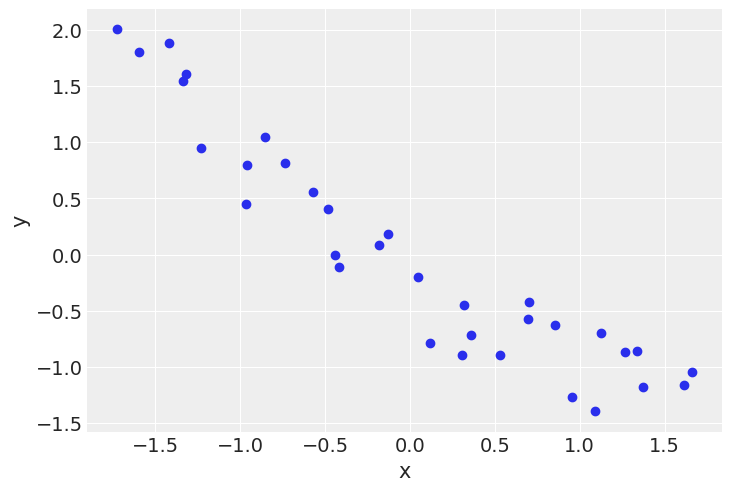

In [47]:
path = "/Users/donaldbrown/Dropbox/Software/PythonCode/PyMC3/9781789341652_Code/data/"
file = "simulated.csv"

sim_data = np.loadtxt(path+file)
x_1 = sim_data[:, 0]
y_1 = sim_data[:, 1]

order = 2
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / \
    x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y')


In [53]:
# Two models: linear, model_l, and polynomial, model_p

with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10)
    σ = pm.HalfNormal('σ', 5)

    μ = α + β * x_1s[0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=σ, observed=y_1s)

    trace_l = pm.sample(2000, cores = 4)

with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=order)
    σ = pm.HalfNormal('σ', 5)

    μ = α + pm.math.dot(β, x_1s)

    y_pred = pm.Normal('y_pred', mu=μ, sd=σ, observed=y_1s)

    trace_p = pm.sample(2000, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.


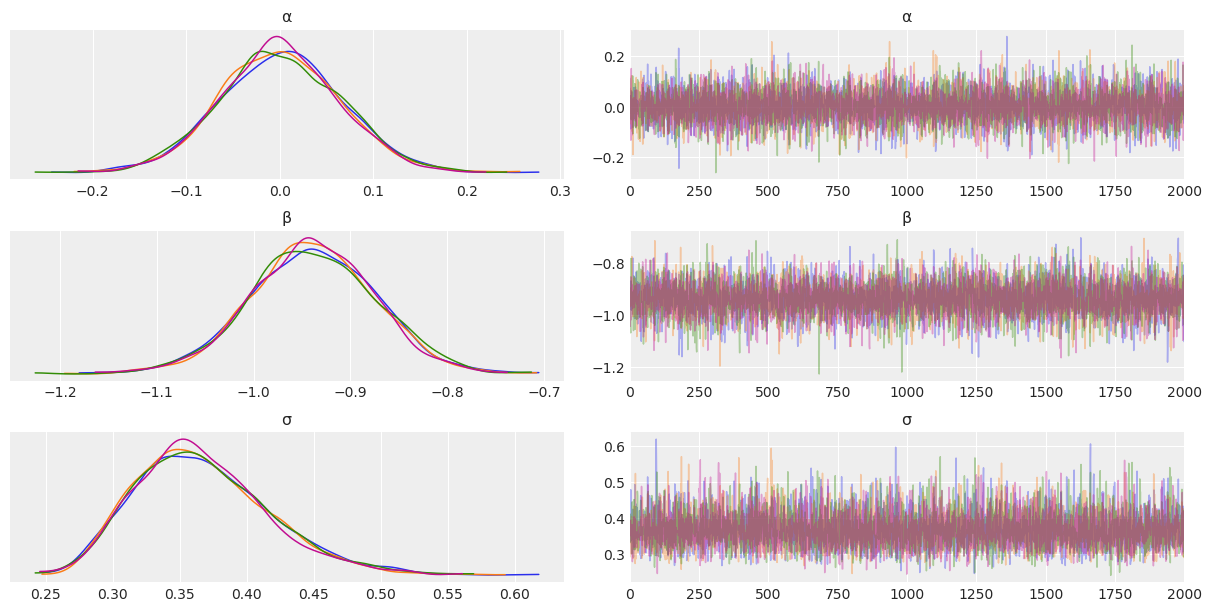

In [55]:
with pm.Model() as model_l:
    az.plot_trace(trace_l)

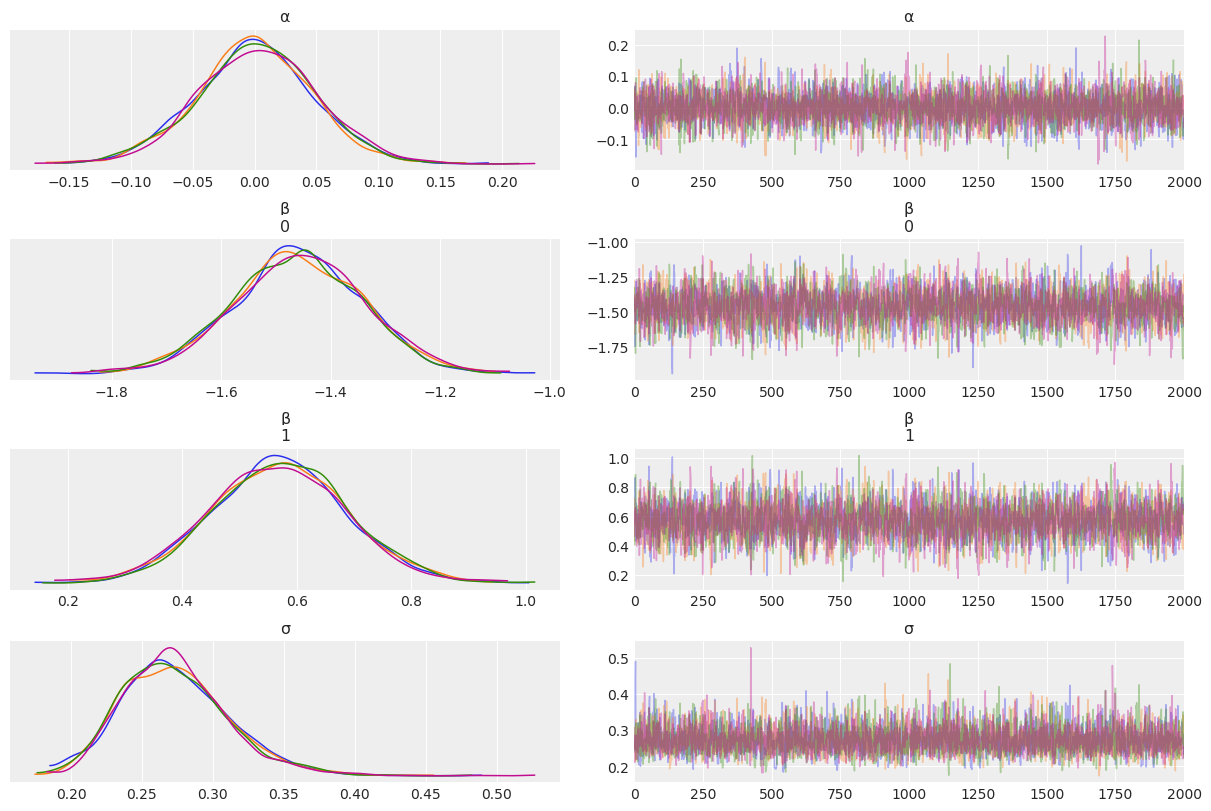

In [56]:
with pm.Model() as model_p:
    az.plot_trace(trace_p)

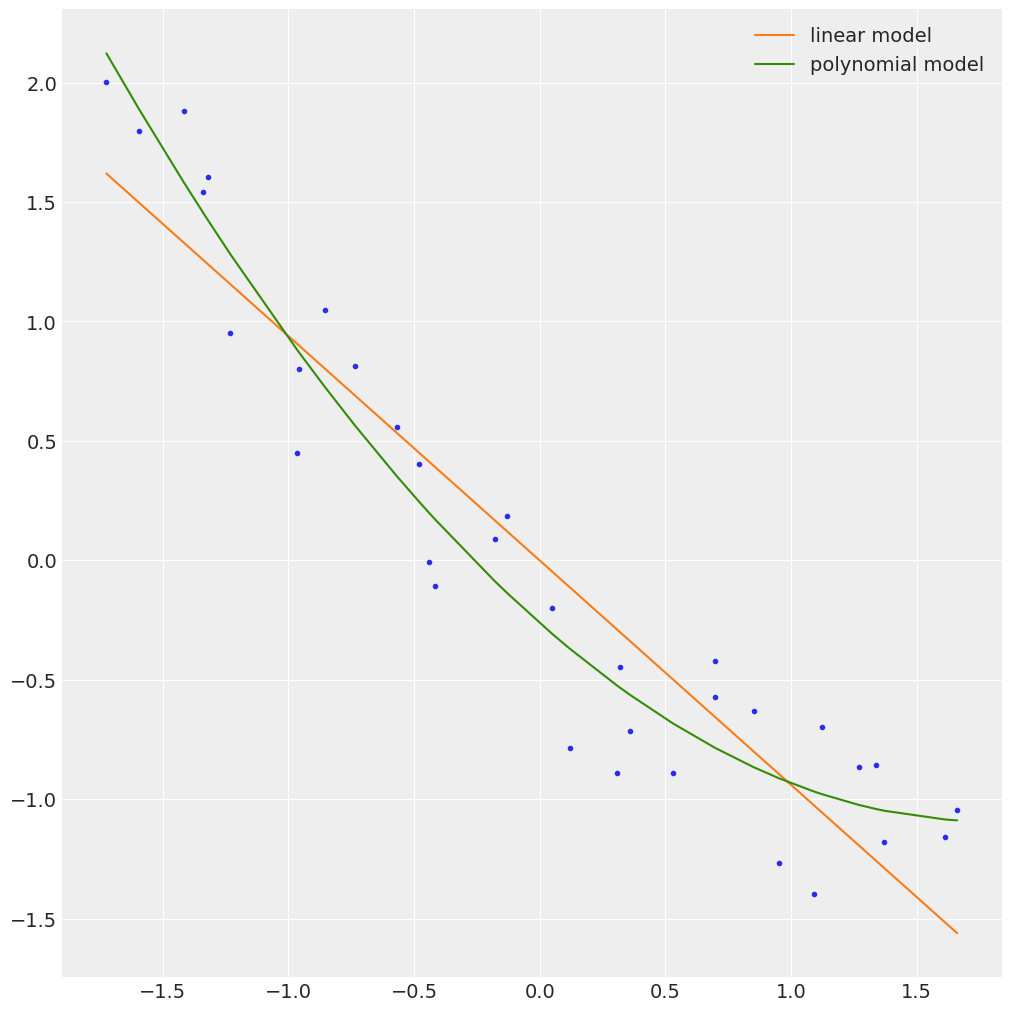

In [118]:
#Plot of both models

x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

α_l_post = trace_l['α'].mean()
β_l_post = trace_l['β'].mean(axis=0)
y_l_post = α_l_post + β_l_post *  x_new

plt.figure(figsize = (10,10))
plt.plot(x_new, y_l_post, 'C1', label='linear model')

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label='polynomial model')

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
x_new_p = np.vstack([x_new**i for i in range(1, order+1)])
y_p_post = α_p_post + np.dot(β_p_post, x_new_p) 


plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend()


## Computing information criteria

In [68]:
with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10)
    σ = pm.HalfNormal('σ', 5)

    μ = α + β * x_1s[0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=σ, observed=y_1s)

    trace_l = pm.sample(2000, cores = 4)
    model_l_idata = az.from_pymc3(model_l_trace)
az.summary(model_l_idata, round_to=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-0.00,0.07,-0.12,0.12,0.0,0.0,9331.11,3775.27,9356.33,5316.29,1.0
β,-0.94,0.07,-1.06,-0.82,0.0,0.0,8777.26,8777.26,8857.42,5335.95,1.0
σ,0.37,0.05,0.28,0.46,0.0,0.0,6983.24,6833.19,6957.58,4434.63,1.0


In [70]:
# WAIC for the linear model

with model_l:
    waic_l = az.waic(trace_l)
waic_l

Computed from 8000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic   -14.35     2.68
p_waic        2.44        -

In [66]:
with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=order)
    σ = pm.HalfNormal('σ', 5)

    μ = α + pm.math.dot(β, x_1s)

    y_pred = pm.Normal('y_pred', mu=μ, sd=σ, observed=y_1s)

    trace_p = pm.sample(2000, cores = 4)
    model_p_idata = az.from_pymc3(model_l_trace)
az.summary(model_p_idata, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8793329816191189, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/arviz/data/io_pymc3.py:314: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-0.00,0.07,-0.12,0.12,0.0,0.0,9331.11,3775.27,9356.33,5316.29,1.0
β,-0.94,0.07,-1.06,-0.82,0.0,0.0,8777.26,8777.26,8857.42,5335.95,1.0
σ,0.37,0.05,0.28,0.46,0.0,0.0,6983.24,6833.19,6957.58,4434.63,1.0


In [67]:
# WAIC for the polynomial model

with model_p:
    waic_p = az.waic(trace_p)
waic_p

Computed from 8000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic    -4.60     2.33
p_waic        2.66        -

In [87]:
# Model comparisons with WAIC and weights

cmp_df = az.compare({'model_l':trace_l, 'model_p':trace_p}, ic = 'WAIC',
                    method='BB-pseudo-BMA')
cmp_df

#Notice with method='pseudo-BMA', we get the values from the 
# formula below for BMA weights
# Weights are used to calculated the ensemble model

/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful resul

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_p,0,-4.5982,2.65754,0,0.998855,2.6078,0,False,log
model_l,1,-14.3532,2.43523,9.75503,0.00114536,2.26016,2.6571,False,log


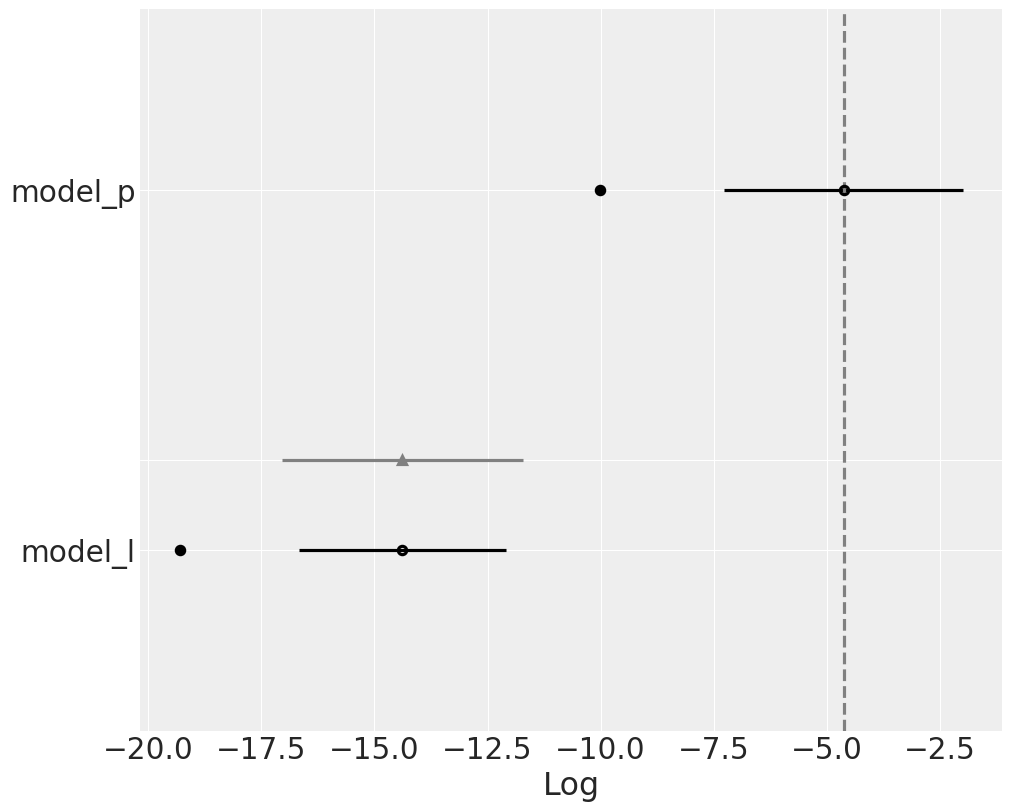

In [73]:
# WAIC comparisons

az.plot_compare(cmp_df, figsize = (10,8));


In [75]:
# LOO-CV for the linear model
with model_l:
    loocv_l = az.loo(trace_l)
loocv_l



Computed from 8000 by 33 log-likelihood matrix

         Estimate       SE
elpd_loo   -14.38     2.68
p_loo        2.46        -

In [76]:
# LOO-CV for the polynomial model

with model_p:
    loocv_p = az.loo(trace_p)
loocv_p

Computed from 8000 by 33 log-likelihood matrix

         Estimate       SE
elpd_loo    -4.63     2.34
p_loo        2.69        -

In [162]:
cmp_df = az.compare({'model_l':trace_l, 'model_p':trace_p}, ic='LOO')
cmp_df

/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_p,0,-4.62842,2.68776,0,0.998334,2.58606,0,False,log
model_l,1,-14.3814,2.46344,9.75303,0.00166551,2.28632,2.66275,False,log


## Pseudo Bayesian Model Averaging
- not weight by posterior probability

In [140]:
# Computing predictions by combining the models using the WAIC weights

#np.exp(-0.5*waic_p[0])/(np.exp(-0.5*waic_l[0]) + np.exp(-0.5*waic_p[0]))
# or use the value given in the table
w = cmp_df.loc['model_p','weight']
# = .5
weights = [w, 1-w]
y_bma = pm.sample_posterior_predictive_w(traces = [trace_l, trace_p],
                                        samples=1000,
                                        models=[model_l, model_p],
                                        weights=weights)

In [149]:
# linear model

y_linear = pm.sample_posterior_predictive_w(traces = [trace_l],
                                        samples=1000,
                                        models=[ model_l])

In [145]:
# polynomial model

y_poly = pm.sample_posterior_predictive_w(traces = [trace_p],
                                        samples=1000,
                                        models=[ model_p])

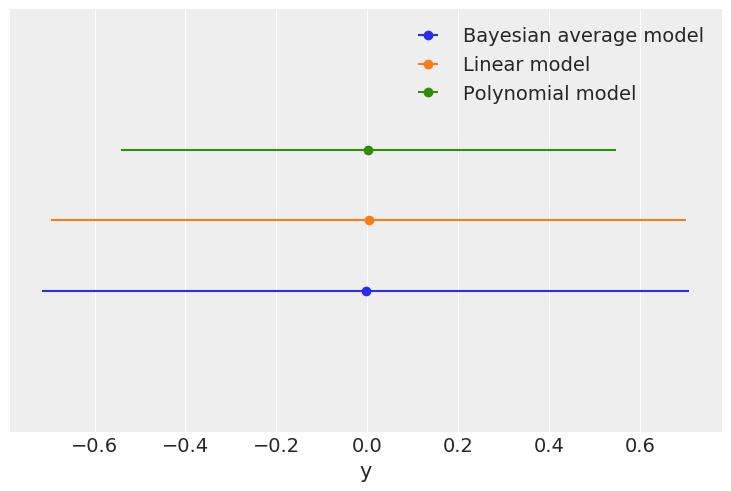

In [159]:
# Comparing average of the predictions

mean_w = y_bma['y_pred'].mean()
hpd_w = pm.hpd(y_bma['y_pred']).mean(0)
mean_linear = y_linear['y_pred'].mean()
hpd_linear = pm.hpd(y_linear['y_pred']).mean(0)
mean_p = y_poly['y_pred'].mean()
hpd_p = pm.hpd(y_poly['y_pred']).mean(0)


plt.errorbar(mean_w, 0, xerr=[[mean_w - hpd_w]], fmt='o', label='Bayesian average model')
plt.errorbar(mean_linear, .5, xerr=[[mean_linear - hpd_linear]], fmt='o', label='Linear model')
plt.errorbar(mean_p, 1, xerr=[[mean_p - hpd_p]], fmt='o', label='Polynomial model')
plt.yticks([])
plt.ylim(-1, 2)
plt.xlabel('y')
plt.legend();

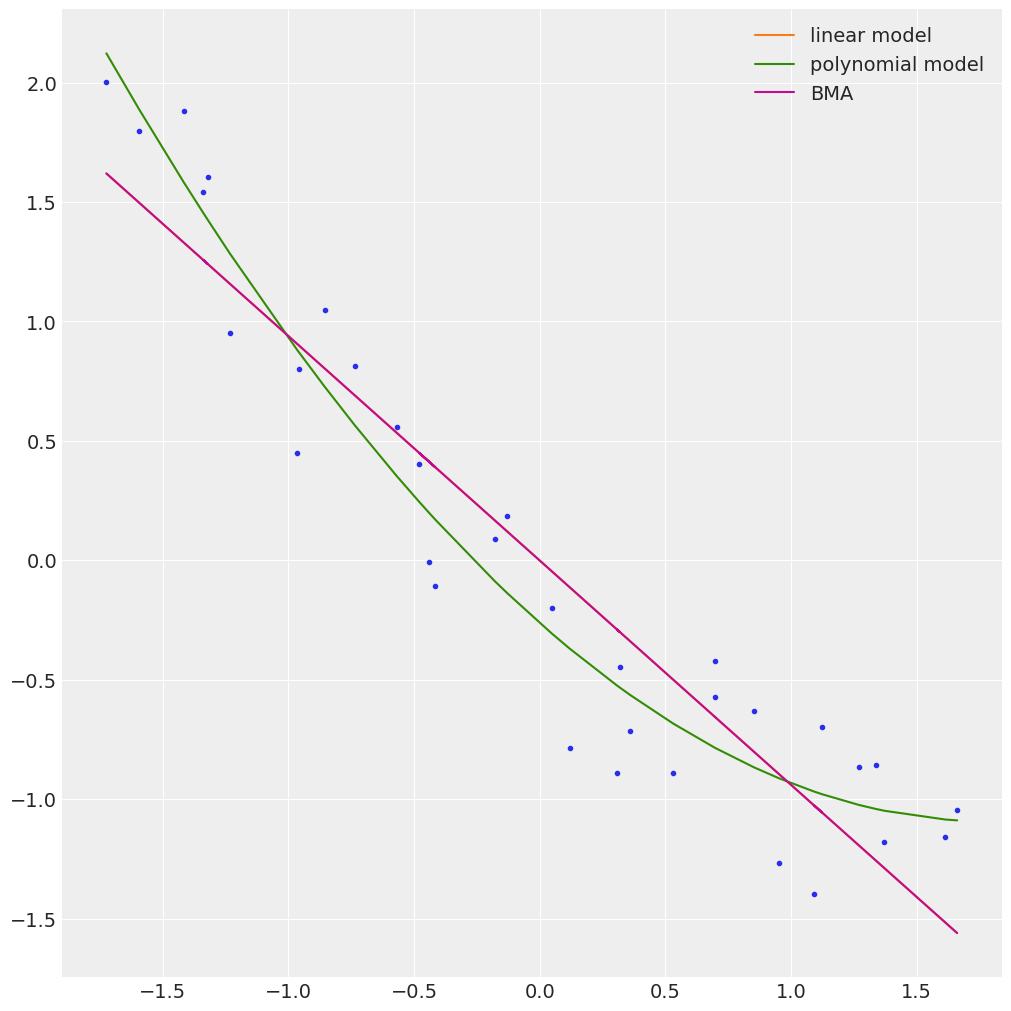

In [139]:
#Plot of both models

x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

α_l_post = trace_l['α'].mean()
β_l_post = trace_l['β'].mean(axis=0)
y_l_post = α_l_post + β_l_post *  x_1s[0]

plt.figure(figsize = (10,10))
plt.plot(x_1s[0], y_l_post, 'C1', label='linear model')

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label='polynomial model')


y_bma = w*y_l_post + (1-w)*y_p_post

plt.plot(x_1s[0], y_bma, c = 'C3'
            , label='BMA')

plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend()


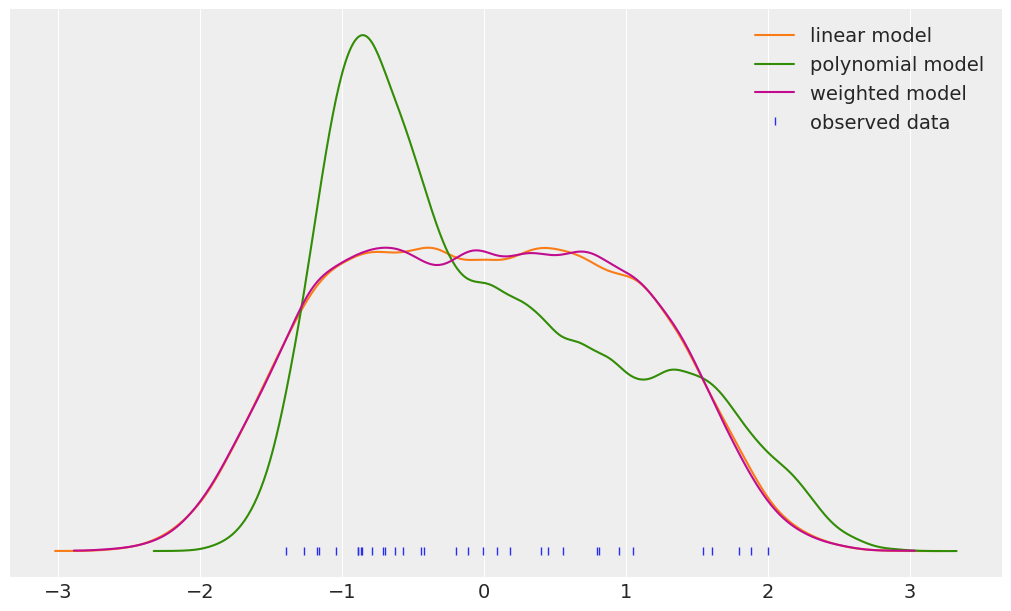

In [153]:
# KDE plots

_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(y_linear['y_pred'], plot_kwargs={'color': 'C1'}, label='linear model', ax=ax)
az.plot_kde(y_poly['y_pred'], plot_kwargs={'color': 'C2'}, label='polynomial model', ax=ax)
az.plot_kde(y_lp['y_pred'], plot_kwargs={'color': 'C3'},
           label='weighted model', ax=ax)

plt.plot(y_1s, np.zeros_like(y_1s), '|', label='observed data')
plt.yticks([])
plt.legend()
